In [1]:
import os
import sys
import gc
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [92]:
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

# 0. 데이터 불러오기

In [4]:
with open('./data/train_v2_201130.json', 'r') as f:
    train = json.load(f)

In [5]:
with open('./data/test_v2_201130.json', 'r') as f:
    test = json.load(f)

In [114]:
with open('./data/User_Meta_v1_201129.json', 'r') as f:
    user_meta = json.load(f)

In [2]:
with open('./data/Wine_Meta_v1_201129.json', 'r') as f:
    wine = json.load(f)

In [3]:
with open('./data/Wine_Token_v1_201129.json', 'r') as f:
    token = json.load(f)

In [4]:
with open('./data/RAW_v2_201130.json', 'r') as f:
    raw = json.load(f)

# 1. DNN train/test set 만들기

In [70]:
df = (pd.DataFrame(zip(
    raw['wine_id'].values(),
    raw['vintage_id'].values(),
    raw['userID'].values(),
    raw['rating_per_user'].values()),
                   columns = ['wine_id', 'vintage_id', 'userID', 'rating'])
     )

In [71]:
df

,wine_id,vintage_id,userID,rating
0,1141133,164942680,19484511,4.0
1,1141133,164942680,352674,4.0
2,1141133,164942680,2148498,1.5
3,1141133,164942680,3450270,4.5
4,1141133,164942680,17786617,4.0
...,...,...,...,...
944094,63654,2435472,11274168,4.0
944095,5602,2293611,11274168,4.5
944096,1396664,8169599,11274168,3.0
944097,1218423,1590767,11274168,4.0


In [72]:
print('wine 개수:', df.wine_id.nunique())
print('vintage 개수:', df.vintage_id.nunique())
print('user 개수:', df.userID.nunique())

wine 개수: 50861
vintage 개수: 307405
user 개수: 6343


In [73]:
user_ids = df['userID'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

wine_ids = df["wine_id"].unique().tolist()
wine2wine_encoded = {x: i for i, x in enumerate(wine_ids)}
wine_encoded2wine = {i: x for i, x in enumerate(wine_ids)}

In [74]:
df_copy = df.copy()

In [75]:
df['userID'] = df["userID"].map(user2user_encoded)
df["wine_id"] = df["wine_id"].map(wine2wine_encoded)

In [76]:
df

,wine_id,vintage_id,userID,rating
0,0,164942680,0,4.0
1,0,164942680,1,4.0
2,0,164942680,2,1.5
3,0,164942680,3,4.5
4,0,164942680,4,4.0
...,...,...,...,...
944094,12120,2435472,5425,4.0
944095,359,2293611,5425,4.5
944096,39281,8169599,5425,3.0
944097,9125,1590767,5425,4.0


In [77]:
df_copy

,wine_id,vintage_id,userID,rating
0,1141133,164942680,19484511,4.0
1,1141133,164942680,352674,4.0
2,1141133,164942680,2148498,1.5
3,1141133,164942680,3450270,4.5
4,1141133,164942680,17786617,4.0
...,...,...,...,...
944094,63654,2435472,11274168,4.0
944095,5602,2293611,11274168,4.5
944096,1396664,8169599,11274168,3.0
944097,1218423,1590767,11274168,4.0


In [82]:
user = df[['userID']].drop_duplicates().reset_index(drop = True).sort_values('userID')
user = user.rename(columns = {'userID' : 'enc_userID'})
user

,userID
0,0
1,1
2,2
3,3
4,4
...,...
6338,6338
6339,6339
6340,6340
6341,6341


In [313]:
df

,wine_id,vintage_id,userID,rating,enc_wine_id,enc_vintage_id,enc_userID
0,1141133,164942680,19484511,4.0,0,164942680,0
1,1141133,164942680,352674,4.0,0,164942680,1
2,1141133,164942680,2148498,1.5,0,164942680,2
3,1141133,164942680,3450270,4.5,0,164942680,3
4,1141133,164942680,17786617,4.0,0,164942680,4
...,...,...,...,...,...,...,...
944094,63654,2435472,11274168,4.0,12120,2435472,5425
944095,5602,2293611,11274168,4.5,359,2293611,5425
944096,1396664,8169599,11274168,3.0,39281,8169599,5425
944097,1218423,1590767,11274168,4.0,9125,1590767,5425


In [87]:
def makedataset(df, user):
    # 모든 user의 소비 wine_id 넣어주기
    history = {}
    recent = []
    label = []
    for u in tqdm(user.userID.unique()):
        history[u] = list(df.loc[df['userID'] == u, 'wine_id']) # 모든 구매내역
        label.append(history[u][-1]) # 마지막 구매
        recent.append(history[u][-11:-1]) # 최근 10개
    
    # 모든 user의 평점&최신 순 wine 뽑기
    like = {}
    dislike = {}
    for u in tqdm(user.userID.unique()):
        temp = df.loc[df['userID']== u].sort_index().iloc[:-1] # label 제외
        like[u] = list(temp.loc[temp['rating'] > 4].reset_index().sort_values(['rating', 'index'], ascending = [False, False])['wine_id'][:10])
        dislike[u] = list(temp.loc[temp['rating'] < 4].reset_index().sort_values(['rating', 'index'], ascending = [True, False])['wine_id'][:10])

    user['history'] = list(history.values())
    user['recent'] = recent
    user['label'] = label
    user['like'] = list(like.values())
    user['dislike'] = list(dislike.values())
    
    return user

In [88]:
user = makedataset(df, user)

100%|██████████| 6343/6343 [00:46<00:00, 137.21it/s]


In [96]:
df.columns = ['enc_wine_id', 'enc_vintage_id', 'enc_userID', 'rating']

In [101]:
df = pd.concat([df_copy, df], axis = 1).iloc[:, :-1]

In [ ]:
user = user[['userID', 'history', 'recent', 'like', 'dislike', 'label']]

## wine_id가 아닌 segment로 user vector 형성

In [319]:
data

,wine_id,vintage_id,userID,rating,enc_wine_id,enc_vintage_id,enc_userID,segment
0,1141133,164942680,19484511,4.0,0,164942680,0,3.0
1,1141133,164942680,352674,4.0,0,164942680,1,3.0
2,1141133,164942680,2148498,1.5,0,164942680,2,3.0
3,1141133,164942680,3450270,4.5,0,164942680,3,3.0
4,1141133,164942680,17786617,4.0,0,164942680,4,3.0
...,...,...,...,...,...,...,...,...
944094,63654,2435472,11274168,4.0,12120,2435472,5425,3.0
944095,5602,2293611,11274168,4.5,359,2293611,5425,3.0
944096,1396664,8169599,11274168,3.0,39281,8169599,5425,1.0
944097,1218423,1590767,11274168,4.0,9125,1590767,5425,0.0


In [325]:
def makedataset(df, user):
    # 모든 user의 소비 wine_id 넣어주기
    history = {}
    recent = []
    label = []
    for u in tqdm(user.enc_userID.unique()):
        history[u] = list(df.loc[df['enc_userID'] == u, 'segment']) # 모든 구매내역
        label.append(history[u][-1]) # 마지막 구매
        recent.append(history[u][-11:-1]) # 최근 10개
    
    # 모든 user의 평점&최신 순 wine 뽑기
    like = {}
    dislike = {}
    for u in tqdm(user.enc_userID.unique()):
        temp = df.loc[df['enc_userID']== u].sort_index().iloc[:-1] # label 제외
        like[u] = list(temp.loc[temp['rating'] > 4].reset_index().sort_values(['rating', 'index'], ascending = [False, False])['segment'][:10])
        dislike[u] = list(temp.loc[temp['rating'] < 4].reset_index().sort_values(['rating', 'index'], ascending = [True, False])['segment'][:10])

    user['history'] = list(history.values())
    user['recent'] = recent
    user['label'] = label
    user['like'] = list(like.values())
    user['dislike'] = list(dislike.values())
    
    return user

In [326]:
user2 = makedataset(data, user)

100%|██████████| 6343/6343 [00:45<00:00, 140.44it/s]


In [327]:
user2

,enc_userID,history,recent,like,dislike,label,follower,following,rating_count,rating_sum,review_count,segment,label
0,0,"[3.0, 0.0, 0.0, 0.0, 3.0, 3.0, 1.0, 3.0, 2.0, ...","[2.0, 1.0, 0.0, 2.0, 0.0, 3.0, 3.0, 1.0, 3.0, ...","[3.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 1.0, 3.0, ...","[0.0, 1.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 1.0, ...",1.0,34.0,65.0,383.0,1453.0,323.0,1.0,1.0
1,1,"[3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, ...",2.0,425.0,915.0,382.0,1516.5,297.0,2.0,2.0
2,2,"[3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0, ...","[1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, ...","[1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, ...","[2.0, 0.0, 3.0, 1.0, 3.0, 3.0, 3.0, 0.0, 3.0, ...",3.0,332.0,47.0,378.0,1168.0,347.0,3.0,3.0
3,3,"[3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0, 1.0, ...","[1.0, 3.0, 2.0, 1.0, 0.0, 3.0, 2.0, 2.0, 3.0, ...","[1.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 0.0, ...","[3.0, 1.0, 0.0, 3.0, 1.0, 1.0, 1.0, 3.0, 0.0, ...",1.0,2.0,2.0,412.0,1602.5,352.0,1.0,1.0
4,4,"[3.0, 3.0, 2.0, 1.0, 2.0, 1.0, 1.0, 3.0, 3.0, ...","[0.0, 2.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, ...","[3.0, 2.0, 1.0, 2.0, 0.0, 3.0, 0.0, 1.0, 2.0, ...",1.0,46.0,75.0,412.0,1589.0,170.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,6338,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, ...",1.0,17.0,16.0,260.0,1107.5,173.0,1.0,1.0
6339,6339,"[1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 3.0, 1.0, 1.0, ...","[0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",1.0,16.0,16.0,260.0,933.0,11.0,1.0,1.0
6340,6340,"[1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 1.0, ...","[3.0, 3.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, ...","[3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 2.0, 2.0, 1.0, ...","[2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, ...",1.0,5.0,1.0,260.0,1115.0,175.0,1.0,1.0
6341,6341,"[2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[1.0, 1.0, 3.0, 3.0, 1.0, 2.0, 1.0, 1.0, 0.0, ...","[2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, ...",2.0,19.0,34.0,259.0,865.5,169.0,2.0,2.0


In [124]:
user_info = (pd.DataFrame(zip(
    user_meta['userID'].values(),
    user_meta['user_follower_count'].values(),
    user_meta['user_following_count'].values(),
    user_meta['user_rating_count'].values(),
    user_meta['user_rating_sum'].values(),
    user_meta['reviews_count'].values())
                         , columns = ['userID', 'follower', 'following', 'rating_count', 'rating_sum', 'review_count']))

In [105]:
import joblib
joblib.dump({
    'data' : df,
    'user' : user
}, 'dataset.pkl')

['dataset.pkl']

In [149]:
enc_user_info = (df.merge(user_info,
                          on = 'userID',
                          how = 'left')[['enc_userID', 'follower', 'following', 'rating_count', 'rating_sum', 'review_count']]
                .drop_duplicates('enc_userID')
                )

In [150]:
enc_user_info

,enc_userID,follower,following,rating_count,rating_sum,review_count
0,0,34.0,65.0,383.0,1453.0,323.0
1,1,425.0,915.0,382.0,1516.5,297.0
2,2,332.0,47.0,378.0,1168.0,347.0
3,3,2.0,2.0,412.0,1602.5,352.0
4,4,46.0,75.0,412.0,1589.0,170.0
...,...,...,...,...,...,...
939795,6338,17.0,16.0,260.0,1107.5,173.0
940171,6339,16.0,16.0,260.0,933.0,11.0
940752,6340,5.0,1.0,260.0,1115.0,175.0
941644,6341,19.0,34.0,259.0,865.5,169.0


In [152]:
user = user.merge(enc_user_info, on = 'enc_userID', how = 'left')

In [156]:
import joblib
joblib.dump({
    'data' : df,
    'user' : user
}, 'dataset.pkl')

['dataset.pkl']

# 2. wine 군집으로 label 만들기

In [213]:
wine.keys()

dict_keys(['name', 'wine_id', 'rating_count', 'rating_average', 'rating_distribution', 'label_count', 'review_count', 'type_id', 'body', 'acidity', 'alcohol', 'food', 'grapes', 'grapes_id', 'grapes_count', 'grape_composition', 'rank', 'region_id', 'region_name', 'country_code', 'country_most_used_grapes_id', 'country_most_used_grapes_name', 'country_most_used_grapes_wines_count', 'winery_id', 'winery_name', 'winery_ratings_count', 'winery_ratings_average', 'winery_labels_count', 'winery_wines_count'])

In [5]:
columns = ['wine_id',
           'name',
           'rating_count',
           'rating_average',
#            'rating_distribution',
           'label_count',
           'review_count',
           'type_id',
           'body', 
           'acidity', 
           'alcohol', 
#            'food', 
           'grapes_id', 
#            'grapes_count', 
#            'grape_composition', 
           'region_id',
           'country_code', 
#            'country_most_used_grapes_id', 
#            'country_most_used_grapes_wines_count', 
           'winery_id', 
           'winery_ratings_count',
           'winery_ratings_average', 
           'winery_labels_count',
           'winery_wines_count']

In [6]:
item = (pd.DataFrame(zip(
    wine['wine_id'].values(), # wine_id
    wine['name'].values(), # wine명
    wine['rating_count'].values(), # wine rating 개수 -> continuous
    wine['rating_average'].values(), # wine rating 평균 -> continuous
#     wine['rating_distribution'].values(), # wine rating
    wine['label_count'].values(), # wine label 개수 -> continuous
    wine['review_count'].values(), # wine review 개수 -> continuous
    wine['type_id'].values(), # wine type -> categorical
    wine['body'].values(), # wine taste - body -> continuous
    wine['acidity'].values(), # wine taste - acidity -> continuous
    wine['alcohol'].values(), # wine taste - alcohol -> continuous
#     wine['food'].values(), # wine with food -> categorical
    wine['grapes_id'].values(), # wine 포도 원산지? -> categorical
#     wine['grapes_count'].values(), # wine 포도 원산지 개수? -> continuous
#     wine['grape_composition'].values(),
#     wine['rank'].values(),
    wine['region_id'].values(), # wine 생산지역 -> categorical
#     wine['region_name'].values(),
    wine['country_code'].values(), # wine 생산국가 -> categorical
#     wine['country_most_used_grapes_id'].values(), wine 생산국가로 구별 가능
#     wine['country_most_used_grapes_wines_count'].values(), wine 생산국가로 구별 가능
    wine['winery_id'].values(), # wine의 winery -> categorical
    wine['winery_ratings_count'].values(),
    wine['winery_ratings_average'].values(),
    wine['winery_labels_count'].values(),
    wine['winery_wines_count'].values())
                    ,columns = columns))

In [7]:
item

,wine_id,name,rating_count,rating_average,label_count,review_count,type_id,body,acidity,alcohol,grapes_id,region_id,country_code,winery_id,winery_ratings_count,winery_ratings_average,winery_labels_count,winery_wines_count
0,1938520,1882 Cabernet Sauvignon,1697,4.1,14879,16,1,5.0,2.0,14.5,[2],105.0,us,2412.0,18888.0,4.3,121618.0,62.0
1,14604,Les Bessards Hermitage,1078,4.3,5370,3,1,5.0,3.0,14.0,[1],535.0,fr,7636.0,72079.0,3.8,462021.0,57.0
2,1930757,Patriarch Estate Grown,1072,4.6,6042,25,1,4.0,3.0,14.2,"[2, 10]",88.0,us,1905.0,7747.0,4.4,49362.0,21.0
3,1564280,Merlot,3577,4.3,18748,52,1,4.0,3.0,14.4,[10],24.0,us,1297.0,14091.0,4.4,83324.0,19.0
4,2576427,Cabernet Sauvignon F Block,115,4.4,806,1,1,5.0,2.0,0.0,[2],42.0,us,2232.0,1077.0,4.4,7749.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50855,1669561,Garganega - Pinot Grigio,788,3.5,6635,9,2,3.0,3.0,0.0,"[104, 34]",983.0,it,19962.0,64503.0,3.4,675950.0,517.0
50856,1861275,Dadà Langhe Chardonnay,231,3.8,961,6,2,3.0,3.0,13.5,[5],613.0,it,17655.0,2573.0,3.9,12719.0,13.0
50857,2201892,Metodo Zero Prosecco Extra Dry,390,3.9,1983,14,3,1.0,3.0,0.0,[112],3232.0,it,13763.0,7521.0,4.0,42703.0,49.0
50858,2396179,Les Monts Damnés Sancerre,302,4.2,730,4,2,4.0,3.0,13.5,[17],635.0,fr,58349.0,2698.0,4.1,8772.0,10.0


In [10]:
categorical_columns = [
    'type_id',
#     'grapes_id',
    'region_id',
    'country_code',
    'winery_id'
]

In [11]:
item[categorical_columns].nunique()

type_id             7
region_id        1909
country_code       54
winery_id       16666
dtype: int64

In [16]:
data = []
item['grapes_id'].fillna('').apply(lambda x : data.extend(x))

0        None
1        None
2        None
3        None
4        None
         ... 
50855    None
50856    None
50857    None
50858    None
50859    None
Name: grapes_id, Length: 50860, dtype: object

In [21]:
grapes = list(set(data))

In [32]:
# categorical columns 이 너무 많아서 일단 삭제
item = item.drop(categorical_columns + ['grapes_id', 'name'], axis = 1)

In [34]:
taste = pd.read_csv('./data/Wine_taste_v1_201129.csv')
food = pd.read_csv('./data/Wine_food_v1_201206.csv')

In [35]:
item = (item
        .merge(food.drop('food', axis = 1), on = 'wine_id', how = 'inner')
        .merge(taste, on = 'wine_id', how = 'inner')
       )

In [37]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [50]:
X = sc.fit_transform(item.fillna(0).iloc[:, 1:])

In [54]:
X = pd.DataFrame(X, columns = item.columns[1:], index = item['wine_id'])

In [58]:
X

,rating_count,rating_average,label_count,review_count,body,acidity_x,alcohol,winery_ratings_count,winery_ratings_average,winery_labels_count,...,dried_fruit_count,dried_fruit_score,dried_fruit_mentions_count,acidity_y,fizziness,intensity,sweetness,tannin,user_structure_count,calculated_structure_count
wine_id,,,,,,,,,,,,,,,,,,,,,
1938520,0.011370,0.854167,0.013070,0.000700,1.0,0.666667,0.107407,0.034977,0.895833,0.030589,...,0.007151,0.004117,0.003202,0.697002,0.000000,0.966102,0.289209,0.723866,0.013329,0.015332
14604,0.007213,0.895833,0.004712,0.000131,1.0,1.000000,0.103704,0.133478,0.791667,0.116208,...,0.004768,0.003101,0.003202,0.685830,0.000000,0.959361,0.340670,0.836162,0.000987,0.006118
1930757,0.007172,0.958333,0.005303,0.001093,0.8,1.000000,0.105185,0.014346,0.916667,0.012416,...,0.008343,0.008332,0.008538,0.770203,0.000000,0.961493,0.303596,0.670473,0.003456,0.009362
1564280,0.023995,0.895833,0.016470,0.002274,0.8,1.000000,0.106667,0.026094,0.916667,0.020958,...,0.013111,0.009931,0.009605,0.355134,0.000000,0.802477,0.397438,0.437128,0.007734,0.035677
2576427,0.000745,0.916667,0.000701,0.000044,1.0,0.666667,0.000000,0.001994,0.916667,0.001949,...,0.000000,0.000000,0.000000,0.702273,0.000000,1.000000,0.254545,0.785367,0.000000,0.000516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554268,0.002854,0.791667,0.001561,0.000743,0.6,1.000000,0.096296,0.018728,0.812500,0.015006,...,0.000000,0.000000,0.000000,0.690352,0.000000,0.736056,0.425667,0.000000,0.003127,0.001695
1669561,0.005265,0.729167,0.005824,0.000394,0.6,1.000000,0.000000,0.119449,0.708333,0.170015,...,0.000000,0.000000,0.000000,0.642572,0.000000,0.724336,0.413339,0.000000,0.003620,0.007593
1861275,0.001524,0.791667,0.000837,0.000262,0.6,1.000000,0.100000,0.004765,0.812500,0.003199,...,0.001192,0.001081,0.001067,0.614535,0.000000,0.784730,0.528585,0.000000,0.001316,0.000958


In [55]:
# 군집분석

In [57]:
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

In [59]:
# 각 군집 수에 따른 SSE(군집내 오차제곱합)와 Silhouette score(군집간 분리도 - 군집내 응집도) 계산하여 리스트로 저장
wss = []
sis = []

for k in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(X)
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(X, kmeans.labels_))

100%|██████████| 8/8 [03:02<00:00, 22.81s/it]


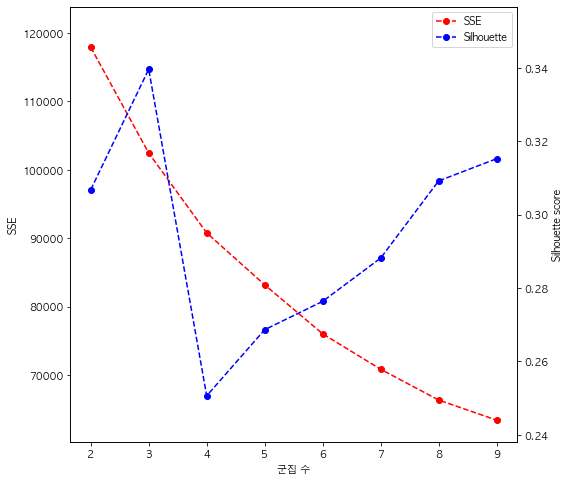

In [62]:
# 군집 수에 따른 SSE와 Silhouette score 시각화

fig, ax1 = plt.subplots(figsize = (8,8))
ax2 = ax1.twinx() # 양쪽 축을 개별로 사용

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show()

In [63]:
import warnings
warnings.filterwarnings(action='ignore') # 경고창 없애기

from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer

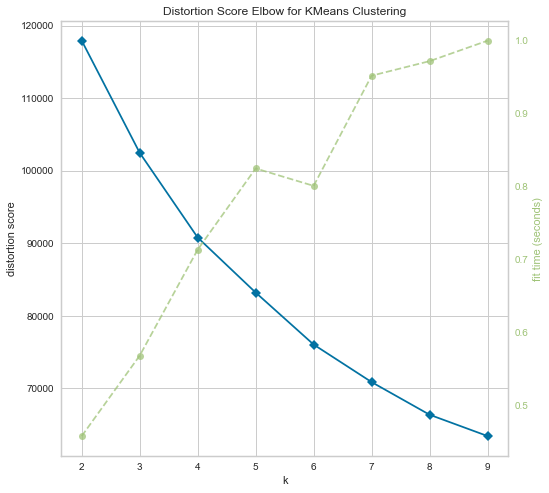

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f914ad7c910>,
                 k=None, model=None)

In [64]:
plt.figure(figsize = (8,8))
kelbow_visualizer(KMeans(random_state=0), X, k=(2,10))

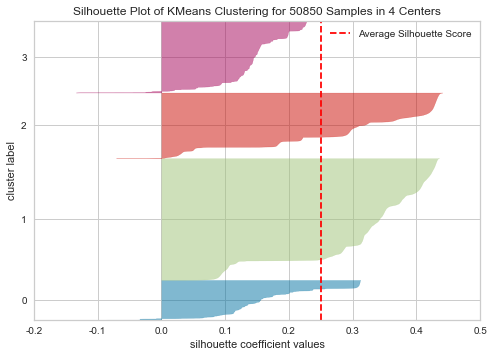

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f90317f1e50>,
                     colors='yellowbrick', model=None)

In [65]:
# 군집이 4개일 때, 실루엣 계수의 평균은 0.2
# 모든 군집이 실루엣 계수를 어느정도 초과했지만, 실루엣 계수 자체가 약간 낮음
silhouette_visualizer(KMeans(4, random_state=0), X, colors='yellowbrick')

In [66]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=0)

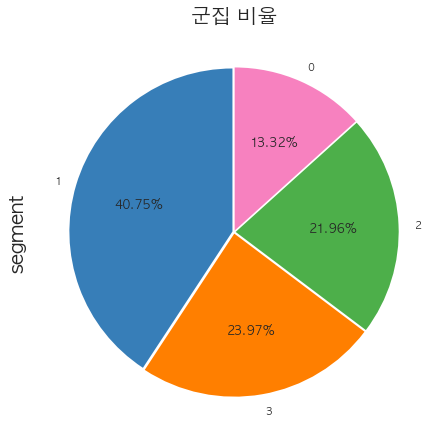

In [93]:
plt.figure(figsize=(7,7))
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf']
explode = [0.01 for j in range(best_k)]
pd.Series(kmeans.labels_).value_counts().plot.pie(autopct='%.2f%%', figsize=(6,6), startangle=90, legend=False, explode = explode, colors = colors)
plt.title("군집 비율", fontsize = 20)
plt.ylabel('segment', fontsize = 20)
plt.tight_layout(pad=0.1, h_pad=0.1)
plt.show()

In [69]:
item['segment'] = kmeans.labels_

In [72]:
item

,wine_id,rating_count,rating_average,label_count,review_count,body,acidity_x,alcohol,winery_ratings_count,winery_ratings_average,...,dried_fruit_score,dried_fruit_mentions_count,acidity_y,fizziness,intensity,sweetness,tannin,user_structure_count,calculated_structure_count,segment
0,1938520,1697,4.1,14879,16,5.0,2.0,14.5,18888.0,4.3,...,381.0,3.0,3.485010,NaN,4.830508,1.446046,3.571554,81.0,208.0,1
1,14604,1078,4.3,5370,3,5.0,3.0,14.0,72079.0,3.8,...,287.0,3.0,3.429150,NaN,4.796805,1.703352,4.125626,6.0,83.0,1
2,1930757,1072,4.6,6042,25,4.0,3.0,14.2,7747.0,4.4,...,771.0,8.0,3.851015,NaN,4.807467,1.517978,3.308112,21.0,127.0,1
3,1564280,3577,4.3,18748,52,4.0,3.0,14.4,14091.0,4.4,...,919.0,9.0,1.775668,NaN,4.012386,1.987188,2.156788,47.0,484.0,1
4,2576427,115,4.4,806,1,5.0,2.0,0.0,1077.0,4.4,...,NaN,NaN,3.511364,NaN,5.000000,1.272727,3.875000,0.0,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50845,1554268,429,3.8,1785,17,3.0,3.0,13.0,10113.0,3.9,...,NaN,NaN,3.451761,NaN,3.680281,2.128333,NaN,19.0,23.0,3
50846,1669561,788,3.5,6635,9,3.0,3.0,0.0,64503.0,3.4,...,NaN,NaN,3.212859,NaN,3.621681,2.066696,NaN,22.0,103.0,3
50847,1861275,231,3.8,961,6,3.0,3.0,13.5,2573.0,3.9,...,100.0,1.0,3.072673,NaN,3.923648,2.642925,NaN,8.0,13.0,3
50848,2201892,390,3.9,1983,14,1.0,3.0,0.0,7521.0,4.0,...,NaN,NaN,3.982507,3.946809,2.062021,NaN,NaN,18.0,41.0,3


In [119]:
import joblib
dataset = joblib.load('dataset.pkl')
locals().update(dataset)

In [79]:
data = data.merge(item[['wine_id', 'segment']], on = 'wine_id', how = 'left')

In [84]:
user = (user.merge(
    data[['wine_id', 'enc_wine_id', 'segment']].drop_duplicates(),
    left_on = 'label', right_on = 'enc_wine_id', how = 'left')
       )

In [85]:
user

,enc_userID,history,recent,like,dislike,label,follower,following,rating_count,rating_sum,review_count,wine_id,enc_wine_id,segment
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[209, 210, 211, 212, 213, 214, 215, 216, 217, ...","[202, 199, 194, 151, 168, 127, 136, 101, 81, 78]","[211, 31, 7, 217, 207, 201, 192, 191, 187, 183]",95,34.0,65.0,383.0,1453.0,323.0,11607,95,1.0
1,1,"[0, 376, 844, 945, 1094, 1721, 1999, 2346, 139...","[9567, 9568, 5735, 9569, 9570, 4129, 9571, 955...","[9540, 9495, 2269, 9455, 9439, 8145, 3149, 314...","[2263, 9526, 9243, 2421, 9570, 5735, 9567, 956...",579,425.0,915.0,382.0,1516.5,297.0,1977,579,2.0
2,2,"[0, 410, 450, 677, 846, 945, 502, 1381, 2339, ...","[15582, 15563, 15583, 15584, 15585, 15586, 155...","[15499, 15545, 15586, 15563, 5289, 3357, 15563...","[15561, 15556, 3703, 1234, 15575, 15569, 15565...",15589,332.0,47.0,378.0,1168.0,347.0,2393529,15589,3.0
3,3,"[0, 164, 184, 677, 767, 1334, 1498, 1920, 1179...","[301, 15651, 21186, 21023, 15530, 5286, 9597, ...","[301, 5115, 14261, 15611, 16222, 21168, 18015,...","[21088, 5831, 5223, 12503, 15386, 21110, 11540...",21156,2.0,2.0,412.0,1602.5,352.0,98006,21156,1.0
4,4,"[0, 163, 225, 1886, 2726, 2099, 4037, 4792, 48...","[21598, 11681, 21599, 18471, 15664, 14586, 216...","[1955, 263, 10077, 4679, 20631, 14038, 4926, 6...","[21600, 190, 31, 21577, 21560, 21545, 14816, 8...",9361,46.0,75.0,412.0,1589.0,170.0,1370933,9361,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,6338,"[769, 1409, 8145, 46902, 6612, 4840, 11316, 40...","[9826, 1387, 1435, 18472, 18472, 40348, 7695, ...","[1324, 6112, 242, 7695, 6468, 6112, 18244, 182...","[18332, 8405, 18472, 18472, 18540, 2002, 2332,...",350,17.0,16.0,260.0,1107.5,173.0,3069,350,1.0
6339,6339,"[3337, 442, 1051, 717, 44543, 31922, 2173, 483...","[6532, 42282, 2743, 4725, 6534, 6608, 6611, 16...","[16955, 6608, 6612, 1848, 19652, 4418, 2573, 7...","[19106, 1337, 6637, 8283, 31902, 12745, 47533,...",953,16.0,16.0,260.0,933.0,11.0,22917,953,1.0
6340,6340,"[2107, 2576, 46476, 2806, 25997, 44159, 5499, ...","[3703, 18113, 5528, 657, 5554, 18238, 1920, 16...","[336, 1920, 18238, 5554, 18113, 3703, 36293, 2...","[813, 38534, 3375, 29261, 17371, 26521, 15006,...",48838,5.0,1.0,260.0,1115.0,175.0,1262858,48838,1.0
6341,6341,"[8574, 19701, 11336, 14057, 1029, 442, 29577, ...","[18980, 36012, 475, 3605, 1677, 10070, 6674, 1...","[1433, 6674, 18980, 49, 6124, 9592, 1213, 1368...","[16610, 2412, 11690, 1163, 36012, 43465, 2301,...",28273,19.0,34.0,259.0,865.5,169.0,1501655,28273,2.0


In [86]:
joblib.dump({
    'dataset' : user
}, './dataset2.pkl')

['./dataset2.pkl']

In [99]:
# food token user vector로 추가

In [98]:
food_token = []
food['food'].apply(lambda x : food_token.extend(x.split('|')))

0        None
1        None
2        None
3        None
4        None
         ... 
50847    None
50848    None
50849    None
50850    None
50851    None
Name: food, Length: 50852, dtype: object

In [101]:
food_token = list(set(food_token))

In [107]:
food_token = list(map(lambda x : x.replace("'", '').strip(), food_token))

In [112]:
food.columns = list(map(lambda x : x.replace("'", '').strip(), food.columns))

In [157]:
food['food'] = food['food'].apply(lambda x : list(map(lambda y : y.replace("'", '').strip(), x.split('|'))))

In [117]:
food_ids = food_token
food2food_encoded = {x: i for i, x in enumerate(food_ids)}
foodencoded2food = {i: x for i, x in enumerate(food_ids)}

In [293]:
food_vector = []
token_vector = []
for u in tqdm(df.userID.unique()):
    temp = df.loc[df['userID'] == u].iloc[:-1]
    wines = temp.loc[temp['rating'] >= 4].sort_values('rating', ascending = False)['wine_id'][:10]
    food_vector.append(list(food.loc[food['wine_id'].isin(wines)].sum(axis = 0).values[2:]))
    token_vector.append(list(token_piv.loc[token_piv['wine_id'].isin(wines)].sum(axis = 0).values[1:]))

100%|██████████| 6343/6343 [00:41<00:00, 154.48it/s]


In [190]:
user = user[list(user.columns[:5]) + list(user.columns[5:]) + [user.columns[5]]]

In [196]:
user = user.drop(['wine_id', 'enc_wine_id'], axis = 1)

In [201]:
y = user.iloc[:, -2:]
X = pd.concat([user.iloc[:, :-2], pd.DataFrame(food_vector)], axis = 1)

In [296]:
X = pd.concat([X, pd.DataFrame(token_vector)], axis = 1)

In [309]:
X

,enc_userID,history,recent,like,dislike,follower,following,rating_count,rating_sum,review_count,...,448,449,450,451,452,453,454,455,456,457
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[209, 210, 211, 212, 213, 214, 215, 216, 217, ...","[202, 199, 194, 151, 168, 127, 136, 101, 81, 78]","[211, 31, 7, 217, 207, 201, 192, 191, 187, 183]",34.0,65.0,383.0,1453.0,323.0,...,1.0,0.0,505.0,106.0,0.0,1.0,12.0,1.0,0.0,12.0
1,1,"[0, 376, 844, 945, 1094, 1721, 1999, 2346, 139...","[9567, 9568, 5735, 9569, 9570, 4129, 9571, 955...","[9540, 9495, 2269, 9455, 9439, 8145, 3149, 314...","[2263, 9526, 9243, 2421, 9570, 5735, 9567, 956...",425.0,915.0,382.0,1516.5,297.0,...,0.0,0.0,1.0,1.0,0.0,1.0,6.0,0.0,0.0,3.0
2,2,"[0, 410, 450, 677, 846, 945, 502, 1381, 2339, ...","[15582, 15563, 15583, 15584, 15585, 15586, 155...","[15499, 15545, 15586, 15563, 5289, 3357, 15563...","[15561, 15556, 3703, 1234, 15575, 15569, 15565...",332.0,47.0,378.0,1168.0,347.0,...,2.0,0.0,4.0,11.0,0.0,1.0,1.0,0.0,0.0,0.0
3,3,"[0, 164, 184, 677, 767, 1334, 1498, 1920, 1179...","[301, 15651, 21186, 21023, 15530, 5286, 9597, ...","[301, 5115, 14261, 15611, 16222, 21168, 18015,...","[21088, 5831, 5223, 12503, 15386, 21110, 11540...",2.0,2.0,412.0,1602.5,352.0,...,0.0,0.0,3.0,14.0,0.0,4.0,5.0,0.0,0.0,2.0
4,4,"[0, 163, 225, 1886, 2726, 2099, 4037, 4792, 48...","[21598, 11681, 21599, 18471, 15664, 14586, 216...","[1955, 263, 10077, 4679, 20631, 14038, 4926, 6...","[21600, 190, 31, 21577, 21560, 21545, 14816, 8...",46.0,75.0,412.0,1589.0,170.0,...,4.0,0.0,8.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,6338,"[769, 1409, 8145, 46902, 6612, 4840, 11316, 40...","[9826, 1387, 1435, 18472, 18472, 40348, 7695, ...","[1324, 6112, 242, 7695, 6468, 6112, 18244, 182...","[18332, 8405, 18472, 18472, 18540, 2002, 2332,...",17.0,16.0,260.0,1107.5,173.0,...,8.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6339,6339,"[3337, 442, 1051, 717, 44543, 31922, 2173, 483...","[6532, 42282, 2743, 4725, 6534, 6608, 6611, 16...","[16955, 6608, 6612, 1848, 19652, 4418, 2573, 7...","[19106, 1337, 6637, 8283, 31902, 12745, 47533,...",16.0,16.0,260.0,933.0,11.0,...,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6340,6340,"[2107, 2576, 46476, 2806, 25997, 44159, 5499, ...","[3703, 18113, 5528, 657, 5554, 18238, 1920, 16...","[336, 1920, 18238, 5554, 18113, 3703, 36293, 2...","[813, 38534, 3375, 29261, 17371, 26521, 15006,...",5.0,1.0,260.0,1115.0,175.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6341,6341,"[8574, 19701, 11336, 14057, 1029, 442, 29577, ...","[18980, 36012, 475, 3605, 1677, 10070, 6674, 1...","[1433, 6674, 18980, 49, 6124, 9592, 1213, 1368...","[16610, 2412, 11690, 1163, 36012, 43465, 2301,...",19.0,34.0,259.0,865.5,169.0,...,3.0,0.0,21.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [306]:
joblib.dump({
    'X' : X,
    'y' : y
}, 'dataset2.pkl')

['dataset2.pkl']

In [203]:
token.keys()

dict_keys(['red_fruit', 'red_fruit_word', 'citrus_fruit', 'citrus_fruit_word', 'non_oak', 'non_oak_word', 'tree_fruit', 'tree_fruit_word', 'microbio', 'microbio_word', 'earth', 'earth_word', 'oak', 'oak_word', 'black_fruit', 'black_fruit_word', 'vegetal', 'vegetal_word', 'spices', 'spices_word', 'floral', 'floral_word', 'tropical_fruit', 'tropical_fruit_word', 'dried_fruit', 'dried_fruit_word'])

In [239]:
wine_token = []
for k in tqdm(token.keys()):
    if 'word' in k:
        continue
    for idx in token[k].keys():
        words = token[k][idx]
        if words == None:
            continue
        for w in words:
            wine_token.append([idx, w.get('name'), w.get('count')])    

100%|██████████| 26/26 [00:03<00:00,  7.88it/s]


In [241]:
wine_token = pd.DataFrame(wine_token, columns = ['wine_id', 'token', 'count'])

In [244]:
token_piv = pd.pivot_table(wine_token, index = 'wine_id', columns = 'token', values = 'count').reset_index().fillna(0)

In [261]:
token_piv

token,wine_id,5-spice powder,acacia,acai berry,aleppo pepper,allspice,almond,anise,aniseed,apple,...,wood smoke,wood varnish,yeast,yellow apple,yellow beet,yellow peach,yellow plum,yellow raisin,yerba mate,yogurt
0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100002,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10001,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50768,9998,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50769,99980,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50770,99984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50771,99986,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [248]:
from sklearn.decomposition import PCA

In [252]:
pca = PCA(5)

In [253]:
p = pca.fit_transform(token_piv)

In [260]:
p = pd.DataFrame(p, index = token_piv.wine_id)
p

,0,1,2,3,4
wine_id,,,,,
10,-1.820812e+06,-45.666686,-13.963511,5.988714,2.023463
10000,-1.810822e+06,-27.391532,-15.908152,5.255965,4.835282
100002,-1.720820e+06,-1.633807,-20.110550,-1.967023,-6.265429
100006,-1.720816e+06,-27.100234,-16.065718,7.718498,-0.549522
10001,-1.810821e+06,-36.638342,-5.339901,18.012670,-1.346098
...,...,...,...,...,...
9998,-1.810824e+06,62.186594,-19.729695,6.462753,-20.275014
99980,-1.720842e+06,-0.130131,-20.138537,-5.721820,-3.163323
99984,-1.720838e+06,-36.118723,-15.110704,2.964363,0.175583


In [269]:
p = p.reset_index()

In [277]:
p.loc[p['wine_id'].isin(wines)]

,wine_id,0,1,2,3,4
4262,1145389,-6.754329e+05,46.005083,-23.185250,-22.468796,39.645708
14936,1261928,-5.588939e+05,156.405727,-27.869188,-54.501249,121.085708
23478,1636302,-1.845199e+05,-12.557351,166.777506,-66.161656,-17.240573
34140,23709,-1.797113e+06,9.479602,959.666782,-467.922633,-97.314273
34994,2448,-1.818374e+06,180.029901,-33.025247,-25.295102,-66.673242
41226,4450,-1.816372e+06,134.634632,-29.019664,-44.252009,108.196565
45835,66534,-1.754288e+06,114.598660,2489.398018,-1259.610015,-292.931944
46897,74346,-1.746476e+06,911.065714,-124.985287,-275.918470,-402.206033
49178,86684,-1.734138e+06,438.007694,2349.845869,-368.965719,63.366393


In [283]:
token_piv.loc[token_piv['wine_id'].isin(wines)]

token,wine_id,5-spice powder,acacia,acai berry,aleppo pepper,allspice,almond,anise,aniseed,apple,...,wood smoke,wood varnish,yeast,yellow apple,yellow beet,yellow peach,yellow plum,yellow raisin,yerba mate,yogurt
4262,1145389,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14936,1261928,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23478,1636302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34140,23709,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,133.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34994,2448,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41226,4450,0.0,0.0,0.0,0.0,1.0,1.0,4.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45835,66534,0.0,1.0,0.0,0.0,0.0,6.0,4.0,0.0,290.0,...,0.0,0.0,3.0,1.0,0.0,2.0,2.0,0.0,0.0,2.0
46897,74346,0.0,1.0,0.0,0.0,3.0,4.0,19.0,5.0,4.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49178,86684,0.0,18.0,0.0,0.0,2.0,453.0,12.0,5.0,1005.0,...,1.0,0.0,384.0,69.0,0.0,1.0,7.0,0.0,0.0,10.0


,0,1,2,3,4,5,6,7,8,9,...,448,449,450,451,452,453,454,455,456,457
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,505.0,106.0,0.0,1.0,12.0,1.0,0.0,12.0
1,0.0,0.0,1.0,1.0,0.0,3.0,0.0,5.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,6.0,0.0,0.0,3.0
2,0.0,0.0,0.0,1.0,1.0,4.0,0.0,4.0,1.0,0.0,...,2.0,0.0,4.0,11.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,4.0,0.0,1.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.0,14.0,0.0,4.0,5.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,5.0,1.0,7.0,0.0,1.0,...,4.0,0.0,8.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,0.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,4.0,...,8.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6339,0.0,0.0,0.0,0.0,0.0,7.0,0.0,10.0,0.0,2.0,...,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6340,0.0,0.0,0.0,0.0,0.0,7.0,0.0,5.0,0.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6341,0.0,1.0,1.0,0.0,0.0,6.0,0.0,6.0,1.0,0.0,...,3.0,0.0,21.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [334]:
user2 = user2.drop(['label', 'segment'], axis = 1)

In [337]:
X

,enc_userID,history,recent,like,dislike,follower,following,rating_count,rating_sum,review_count,...,448,449,450,451,452,453,454,455,456,457
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[209, 210, 211, 212, 213, 214, 215, 216, 217, ...","[202, 199, 194, 151, 168, 127, 136, 101, 81, 78]","[211, 31, 7, 217, 207, 201, 192, 191, 187, 183]",34.0,65.0,383.0,1453.0,323.0,...,1.0,0.0,505.0,106.0,0.0,1.0,12.0,1.0,0.0,12.0
1,1,"[0, 376, 844, 945, 1094, 1721, 1999, 2346, 139...","[9567, 9568, 5735, 9569, 9570, 4129, 9571, 955...","[9540, 9495, 2269, 9455, 9439, 8145, 3149, 314...","[2263, 9526, 9243, 2421, 9570, 5735, 9567, 956...",425.0,915.0,382.0,1516.5,297.0,...,0.0,0.0,1.0,1.0,0.0,1.0,6.0,0.0,0.0,3.0
2,2,"[0, 410, 450, 677, 846, 945, 502, 1381, 2339, ...","[15582, 15563, 15583, 15584, 15585, 15586, 155...","[15499, 15545, 15586, 15563, 5289, 3357, 15563...","[15561, 15556, 3703, 1234, 15575, 15569, 15565...",332.0,47.0,378.0,1168.0,347.0,...,2.0,0.0,4.0,11.0,0.0,1.0,1.0,0.0,0.0,0.0
3,3,"[0, 164, 184, 677, 767, 1334, 1498, 1920, 1179...","[301, 15651, 21186, 21023, 15530, 5286, 9597, ...","[301, 5115, 14261, 15611, 16222, 21168, 18015,...","[21088, 5831, 5223, 12503, 15386, 21110, 11540...",2.0,2.0,412.0,1602.5,352.0,...,0.0,0.0,3.0,14.0,0.0,4.0,5.0,0.0,0.0,2.0
4,4,"[0, 163, 225, 1886, 2726, 2099, 4037, 4792, 48...","[21598, 11681, 21599, 18471, 15664, 14586, 216...","[1955, 263, 10077, 4679, 20631, 14038, 4926, 6...","[21600, 190, 31, 21577, 21560, 21545, 14816, 8...",46.0,75.0,412.0,1589.0,170.0,...,4.0,0.0,8.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,6338,"[769, 1409, 8145, 46902, 6612, 4840, 11316, 40...","[9826, 1387, 1435, 18472, 18472, 40348, 7695, ...","[1324, 6112, 242, 7695, 6468, 6112, 18244, 182...","[18332, 8405, 18472, 18472, 18540, 2002, 2332,...",17.0,16.0,260.0,1107.5,173.0,...,8.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6339,6339,"[3337, 442, 1051, 717, 44543, 31922, 2173, 483...","[6532, 42282, 2743, 4725, 6534, 6608, 6611, 16...","[16955, 6608, 6612, 1848, 19652, 4418, 2573, 7...","[19106, 1337, 6637, 8283, 31902, 12745, 47533,...",16.0,16.0,260.0,933.0,11.0,...,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6340,6340,"[2107, 2576, 46476, 2806, 25997, 44159, 5499, ...","[3703, 18113, 5528, 657, 5554, 18238, 1920, 16...","[336, 1920, 18238, 5554, 18113, 3703, 36293, 2...","[813, 38534, 3375, 29261, 17371, 26521, 15006,...",5.0,1.0,260.0,1115.0,175.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6341,6341,"[8574, 19701, 11336, 14057, 1029, 442, 29577, ...","[18980, 36012, 475, 3605, 1677, 10070, 6674, 1...","[1433, 6674, 18980, 49, 6124, 9592, 1213, 1368...","[16610, 2412, 11690, 1163, 36012, 43465, 2301,...",19.0,34.0,259.0,865.5,169.0,...,3.0,0.0,21.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [336]:
pd.concat([user2, X.iloc[:, 10:]], axis = 1)

,enc_userID,history,recent,like,dislike,follower,following,rating_count,rating_sum,review_count,...,448,449,450,451,452,453,454,455,456,457
0,0,"[3.0, 0.0, 0.0, 0.0, 3.0, 3.0, 1.0, 3.0, 2.0, ...","[2.0, 1.0, 0.0, 2.0, 0.0, 3.0, 3.0, 1.0, 3.0, ...","[3.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 1.0, 3.0, ...","[0.0, 1.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 1.0, ...",34.0,65.0,383.0,1453.0,323.0,...,1.0,0.0,505.0,106.0,0.0,1.0,12.0,1.0,0.0,12.0
1,1,"[3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, ...",425.0,915.0,382.0,1516.5,297.0,...,0.0,0.0,1.0,1.0,0.0,1.0,6.0,0.0,0.0,3.0
2,2,"[3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0, ...","[1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, ...","[1.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, ...","[2.0, 0.0, 3.0, 1.0, 3.0, 3.0, 3.0, 0.0, 3.0, ...",332.0,47.0,378.0,1168.0,347.0,...,2.0,0.0,4.0,11.0,0.0,1.0,1.0,0.0,0.0,0.0
3,3,"[3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0, 1.0, ...","[1.0, 3.0, 2.0, 1.0, 0.0, 3.0, 2.0, 2.0, 3.0, ...","[1.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 0.0, ...","[3.0, 1.0, 0.0, 3.0, 1.0, 1.0, 1.0, 3.0, 0.0, ...",2.0,2.0,412.0,1602.5,352.0,...,0.0,0.0,3.0,14.0,0.0,4.0,5.0,0.0,0.0,2.0
4,4,"[3.0, 3.0, 2.0, 1.0, 2.0, 1.0, 1.0, 3.0, 3.0, ...","[0.0, 2.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, ...","[3.0, 2.0, 1.0, 2.0, 0.0, 3.0, 0.0, 1.0, 2.0, ...",46.0,75.0,412.0,1589.0,170.0,...,4.0,0.0,8.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,6338,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, ...",17.0,16.0,260.0,1107.5,173.0,...,8.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6339,6339,"[1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 3.0, 1.0, 1.0, ...","[0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",16.0,16.0,260.0,933.0,11.0,...,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6340,6340,"[1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 1.0, ...","[3.0, 3.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, ...","[3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 2.0, 2.0, 1.0, ...","[2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, ...",5.0,1.0,260.0,1115.0,175.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6341,6341,"[2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[1.0, 1.0, 3.0, 3.0, 1.0, 2.0, 1.0, 1.0, 0.0, ...","[2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, ...",19.0,34.0,259.0,865.5,169.0,...,3.0,0.0,21.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
